Import libraries

In [ ]:
import glob
import io
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
plt.gray()

<Figure size 432x288 with 0 Axes>

Mount Google drive to access data

In [ ]:
drive.mount('/content/drive')
data = glob.glob ("/content/drive/My Drive/smallfer (1).csv")
data = open(data[0],'r').read()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parse data

In [ ]:
str_data = io.StringIO(data)
df = pd.read_csv(str_data)
lines = np.array(df)

Constants

In [ ]:
num_instances=lines.shape[0]
train_size = 1500
test_size = 649
num_classes = 7
img_size = 90


Extract image and classification fields and divide data into train and test sets

In [ ]:
x_train_raw, y_train, x_test_raw, y_test = [],[],[],[]
for i in range (num_instances):
  emotion, img = lines[i][0], lines[i][1]
  val = img.split (" ")
  pixels = np.array(val, 'float32')
  pixels = pixels.reshape((48,48,1))
  emotion = keras.utils.to_categorical (emotion, num_classes)
  if (i<train_size):
    x_train_raw.append (pixels)
    y_train.append (emotion)
  else:
    x_test_raw.append(pixels)
    y_test.append (emotion)
    
y_train = np.concatenate (y_train).reshape (train_size, num_classes)
y_test = np.concatenate (y_test).reshape (test_size, num_classes)  


#Data Preprocessing

Before processing

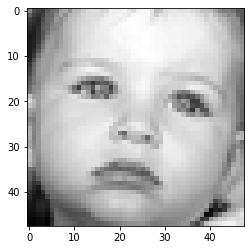

In [ ]:
plt.imshow (tf.squeeze(x_test_raw[0]))

Image Resizing to 90 x 90 px

In [ ]:
#Resize each image to 90 x 90
x_train_rs, x_test_rs=[], []
for i in range(len(x_train_raw)):
  x_train_rs.append(tf.image.resize (x_train_raw[i], [img_size,img_size], method = 'bilinear'))

for i in range (len(x_test_raw)):
  x_test_rs.append (tf.image.resize (x_test_raw[i], [img_size, img_size], method = 'bilinear'))


After resizing

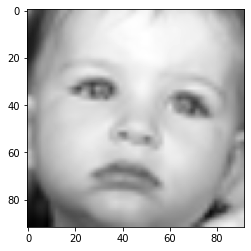

In [ ]:
plt.imshow (tf.squeeze(x_test_rs[0]))

Image equalization

In [ ]:
x_test_eq, x_train_eq = [],[]
for i in range(train_size):
  image = x_train_rs[i]
  values_range = tf.constant([0., 255.], dtype = tf.float32)
  histogram = tf.histogram_fixed_width(tf.cast(image, tf.float32), values_range, 256)
  cdf = tf.cumsum(histogram)
  cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

  img_shape = tf.shape(image)
  pix_cnt = img_shape[-3] * img_shape[-2]
  px_map = tf.round(tf.cast(cdf - cdf_min, tf.float32) * 255. / tf.cast(pix_cnt - 1, tf.float32))
  px_map = tf.cast(px_map, tf.int32)

  eq_hist = tf.expand_dims(tf.gather_nd(px_map, tf.cast(image, tf.int32)), 2)
  x_train_eq.append(eq_hist)

for i in range(test_size):
  image = x_test_rs[i]
  values_range = tf.constant([0., 255.], dtype = tf.float32)
  histogram = tf.histogram_fixed_width(tf.cast(image, tf.float32), values_range, 256)
  cdf = tf.cumsum(histogram)
  cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

  img_shape = tf.shape(image)
  pix_cnt = img_shape[-3] * img_shape[-2]
  px_map = tf.round(tf.cast(cdf - cdf_min, tf.float32) * 255. / tf.cast(pix_cnt - 1, tf.float32))
  px_map = tf.cast(px_map, tf.int32)

  eq_hist = tf.expand_dims(tf.gather_nd(px_map, tf.cast(image, tf.int32)), 2)
  x_test_eq.append(eq_hist)


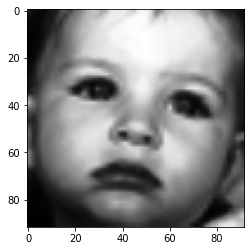

In [ ]:
plt.imshow (tf.squeeze(x_test_eq[0]), cmap = 'gray')


Kirsch Edge operation

In [ ]:
h1 = np.array([[5, -3, -3], [-5, 0, -3], [5, -3, -3]], dtype=np.float32)/ 15
h2 = np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]], dtype=np.float32) / 15
h3 = np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]], dtype=np.float32) / 15
h4 = np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]], dtype=np.float32) / 15
h5 = np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]], dtype=np.float32) / 15
h6 = np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]], dtype=np.float32) / 15
h7 = np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]], dtype=np.float32) / 15
h8 = np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]], dtype=np.float32) / 15


x_test_ed, x_train_ed = [], []
x_temp=[None]*8
for i in range(test_size):
  x_temp[0]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h1, mode='full', boundary='fill', fillvalue=0)
  x_temp[1]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h2, mode='full', boundary='fill', fillvalue=0)
  x_temp[2]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h3, mode='full', boundary='fill', fillvalue=0)
  x_temp[3]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h4, mode='full', boundary='fill', fillvalue=0)
  x_temp[4]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h5, mode='full', boundary='fill', fillvalue=0)
  x_temp[5]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h6, mode='full', boundary='fill', fillvalue=0)
  x_temp[6]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h7, mode='full', boundary='fill', fillvalue=0)
  x_temp[7]=signal.convolve2d(tf.squeeze(x_test_eq[i]), h8, mode='full', boundary='fill', fillvalue=0)
  x_fin = tf.stack ([x_temp[0],x_temp[1],x_temp[2],x_temp[3],x_temp[4],x_temp[5],x_temp[6],x_temp[7]], axis = 2)
  x_test_ed.append( tf.math.reduce_max (x_fin, axis = 2))

for i in range(train_size):
  x_temp[0]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h1, mode='full', boundary='fill', fillvalue=0)
  x_temp[1]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h2, mode='full', boundary='fill', fillvalue=0)
  x_temp[2]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h3, mode='full', boundary='fill', fillvalue=0)
  x_temp[3]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h4, mode='full', boundary='fill', fillvalue=0)
  x_temp[4]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h5, mode='full', boundary='fill', fillvalue=0)
  x_temp[5]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h6, mode='full', boundary='fill', fillvalue=0)
  x_temp[6]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h7, mode='full', boundary='fill', fillvalue=0)
  x_temp[7]=signal.convolve2d(tf.squeeze(x_train_eq[i]), h8, mode='full', boundary='fill', fillvalue=0)
  x_fin = tf.stack ([x_temp[0],x_temp[1],x_temp[2],x_temp[3],x_temp[4],x_temp[5],x_temp[6],x_temp[7]], axis = 2)
  x_train_ed.append(tf.math.reduce_max (x_fin, axis = 2))

x_train_ed = tf.expand_dims(tf.convert_to_tensor (x_train_ed, dtype = tf.float32), axis =3)
x_test_ed = tf.expand_dims(tf.convert_to_tensor (x_test_ed, dtype = tf.float32), axis =3)


After edge detection

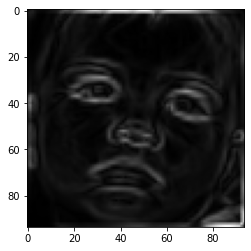

In [ ]:
plt.imshow (tf.squeeze(x_test_ed[0]))

# Training

In [ ]:
keras.backend.clear_session()
model = Sequential()
#1st convolution layer C1
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(92,92,1)))
 
#2nd convolution layer C2
model.add(Conv2D(64, (5, 5), activation='relu'))

#1st Maxpool layer S1
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
 
#3rd convolution layer C3
model.add(Conv2D(128, (5, 5), activation='relu'))

#2nd Maxpool layer S2
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
 
 
#fully connected neural networks
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
batch_size = 8
epochs = 75
gen = ImageDataGenerator()

train_generator = gen.flow(x_train_ed, y_train)
model.compile(loss='categorical_crossentropy'
, optimizer=keras.optimizers.Adam()
, metrics=['accuracy']
)
 
history = model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)

Epoch 1/75
8/8 [==============================] - 23s 3s/step - loss: 64.9205 - accuracy: 0.1523
Epoch 2/75
8/8 [==============================] - 22s 3s/step - loss: 1.9122 - accuracy: 0.1953
Epoch 3/75
8/8 [==============================] - 22s 3s/step - loss: 1.9138 - accuracy: 0.1706
Epoch 4/75
8/8 [==============================] - 22s 3s/step - loss: 1.8503 - accuracy: 0.2539
Epoch 5/75
8/8 [==============================] - 22s 3s/step - loss: 1.7369 - accuracy: 0.3016
Epoch 6/75
8/8 [==============================] - 22s 3s/step - loss: 1.7650 - accuracy: 0.3254
Epoch 7/75
8/8 [==============================] - 22s 3s/step - loss: 1.6495 - accuracy: 0.3633
Epoch 8/75
8/8 [==============================] - 22s 3s/step - loss: 1.6041 - accuracy: 0.3984
Epoch 9/75
8/8 [==============================] - 22s 3s/step - loss: 1.5928 - accuracy: 0.4062
Epoch 10/75
8/8 [==============================] - 22s 3s/step - loss: 1.4307 - accuracy: 0.4727
Epoch 11/75
8/8 [=====================

Plotting data

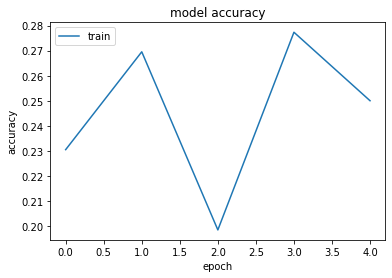

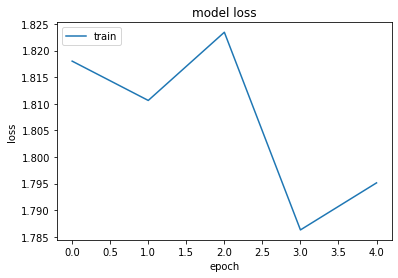

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Metrics

In [ ]:
model.compile(loss='categorical_crossentropy'
, optimizer=keras.optimizers.Adam()
, metrics=['accuracy']
)100
history = model.fit (x_train_ed, y_train, batch_size = 8, epochs = 10 )

Epoch 1/10
188/188 [==============================] - 163s 867ms/step - loss: 2.6560 - accuracy: 0.2100
Epoch 2/10
188/188 [==============================] - 163s 864ms/step - loss: 1.8219 - accuracy: 0.2480
Epoch 3/10
188/188 [==============================] - 163s 865ms/step - loss: 1.8118 - accuracy: 0.2360
Epoch 4/10
188/188 [==============================] - 162s 863ms/step - loss: 1.8111 - accuracy: 0.2540
Epoch 5/10
188/188 [==============================] - 162s 864ms/step - loss: 1.7487 - accuracy: 0.2707
Epoch 6/10
188/188 [==============================] - 162s 863ms/step - loss: 1.6156 - accuracy: 0.3393
Epoch 7/10
188/188 [==============================] - 162s 864ms/step - loss: 1.4014 - accuracy: 0.4567
Epoch 8/10
188/188 [==============================] - 162s 864ms/step - loss: 1.0993 - accuracy: 0.5873
Epoch 9/10
188/188 [==============================] - 163s 865ms/step - loss: 0.7174 - accuracy: 0.7613
Epoch 10/10
188/188 [==============================] - 162s 864m

In [ ]:
]train_score = model.evaluate (x_train_ed, y_train, verbose = 0)
print ("Train loss\t", train_score[0])
print ("Train accuracy\t", train_score[1] )

Train loss	 0.020085658878087997
Train accuracy	 0.9953333139419556


In [ ]:
test_score = model.evaluate (x_test_ed, y_test, verbose = 0)
print ("Test loss\t", test_score[0])
print ("Test accuracy\t",test_score[1])

Test loss	 1.8814870119094849
Test accuracy	 0.7765793800354004
